In [1]:
from dotenv import dotenv_values
import pymongo
from elasticsearch import Elasticsearch
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta
import time
from SPARQLWrapper import SPARQLWrapper, POST, JSON, CSV

In [2]:
env_config = dotenv_values("./maadm-gesbd-hackathon/.env")

In [3]:
n_querys_mongo = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
n_querys_graph = [100, 500, 1000, 5000, 10000]

## MongoDB

In [4]:
mongo_client = pymongo.MongoClient(
    host=env_config['MONGODB_HOST'],
    port=int(env_config['MONGODB_PORT']),
    username=env_config['MONGO_USER'],
    password=env_config['MONGO_PASSWORD'],
)
mongo_collection = mongo_client["boe_db"]["boe"]

In [5]:
times_mongo = {}

In [6]:
def batch_timing_mongo(batch_querys):
    
    timer_start = time.time()
    for query in batch_querys:
        mongo_collection.find(query)
    timer_end = time.time()

    elapsed_time = timer_end - timer_start
    print(f"Tiempo de ejecución para {n} querys: {elapsed_time:.5f}")
    return elapsed_time


### Por fecha

In [7]:
times_dates = {}
start_date_data = datetime.strptime('2023-01-01', '%Y-%m-%d')

for n in n_querys_mongo:
    batch_querys = []
    for i in range(n):
        start_date = start_date_data + timedelta(days=int(random.random() * 365))
        end_date = start_date + timedelta(days=1)
        query_fecha = {
                    "fecha_publicacion": {
                        "$gte": start_date,
                        "$lte": end_date,
                    }
                }
        batch_querys.append(query_fecha)
    times_dates[n] = batch_timing_mongo(batch_querys)

times_mongo['fecha'] = times_dates

Tiempo de ejecución para 1000 querys: 0.00500
Tiempo de ejecución para 5000 querys: 0.02303
Tiempo de ejecución para 10000 querys: 0.04600
Tiempo de ejecución para 50000 querys: 0.23000
Tiempo de ejecución para 100000 querys: 0.46590
Tiempo de ejecución para 500000 querys: 2.25567
Tiempo de ejecución para 1000000 querys: 4.47413


### Por indentificador

In [8]:
identificadores = mongo_collection.distinct('identificador')
times_identificadores = {}
for n in n_querys_mongo:
    batch_querys = []
    for i in range(n):
        query_identificador = {
                    "identificador": random.choice(identificadores)
                }
        batch_querys.append(query_identificador)
    times_identificadores[n] = batch_timing_mongo(batch_querys)
times_mongo['identificador'] = times_identificadores

Tiempo de ejecución para 1000 querys: 0.00500
Tiempo de ejecución para 5000 querys: 0.02397
Tiempo de ejecución para 10000 querys: 0.05000
Tiempo de ejecución para 50000 querys: 0.22803
Tiempo de ejecución para 100000 querys: 0.43503
Tiempo de ejecución para 500000 querys: 2.17973
Tiempo de ejecución para 1000000 querys: 4.53281


### Por materia

In [9]:
codigos = mongo_collection.distinct('materias.codigo')

for n in n_querys_mongo:
    batch_querys = []
    for i in range(n):
        query_codigo = {
                    "materias.codigo": random.choice(codigos)
                }
        batch_querys.append(query_codigo)
    times_identificadores[n] = batch_timing_mongo(batch_querys)
times_mongo['codigo'] = times_identificadores

Tiempo de ejecución para 1000 querys: 0.00400
Tiempo de ejecución para 5000 querys: 0.02200
Tiempo de ejecución para 10000 querys: 0.04497
Tiempo de ejecución para 50000 querys: 0.22595
Tiempo de ejecución para 100000 querys: 0.44864
Tiempo de ejecución para 500000 querys: 2.18579
Tiempo de ejecución para 1000000 querys: 4.45644


### Plot de resultados

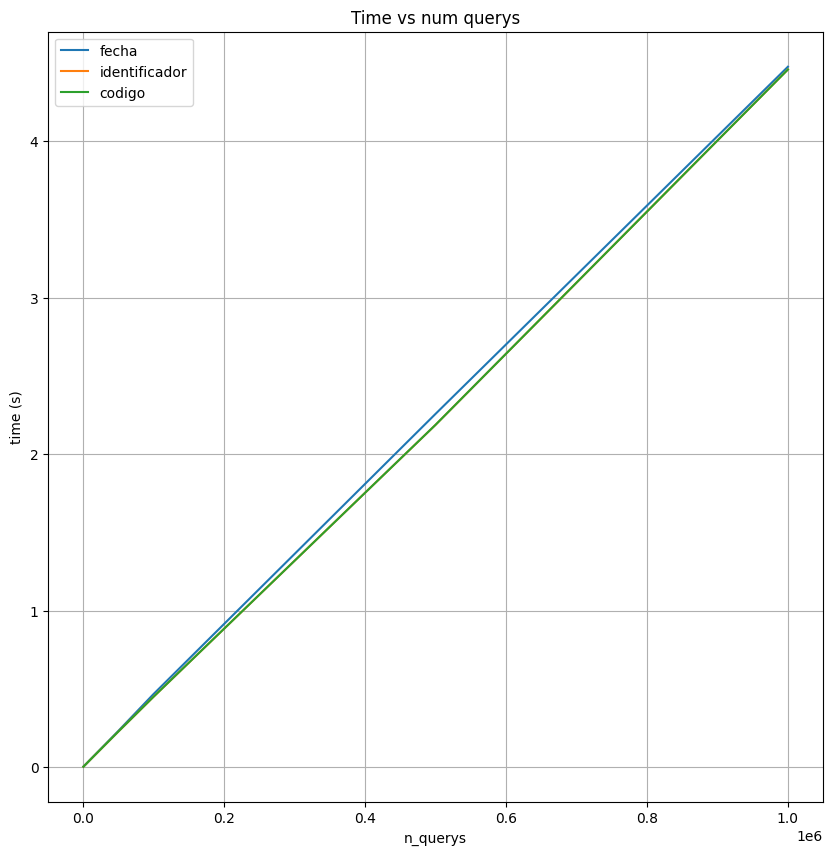

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
for query_type in times_mongo:
    ax.plot(n_querys_mongo, times_mongo[query_type].values(), label=query_type)
ax.set(xlabel='n_querys', ylabel='time (s)', title='Time vs num querys')
ax.grid()
ax.legend()
plt.show()

## GraphDB

In [11]:
times_graph = {}

In [12]:
sparql = SPARQLWrapper(
    f"http://{env_config['GRAPHDB_HOST']}:{env_config['GRAPHDB_PORT']}"
    f"/repositories/{env_config['GRAPHDB_REPOSITORY']}"
)
sparql.setMethod(POST)

In [13]:
def batch_timing_graph(batch_querys):
    
    timer_start = time.time()
    for query in batch_querys:
        sparql.setReturnFormat(JSON)
        sparql.setQuery(query)
        results = sparql.query().convert()
    timer_end = time.time()

    elapsed_time = timer_end - timer_start
    print(f"Tiempo de ejecución para {n} querys: {elapsed_time:.5f}")
    return elapsed_time

In [14]:
PREFIXES = """
PREFIX  :     <http://www.semanticweb.org/hackathon/ontology/>
PREFIX  owl:  <http://www.w3.org/2002/07/owl#>
PREFIX  rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX  xml:  <http://www.w3.org/XML/1998/namespace>
PREFIX  xsd:  <http://www.w3.org/2001/XMLSchema#>
PREFIX  rdfs: <http://www.w3.org/2000/01/rdf-schema#>
"""

### Por fecha

In [15]:
def encode_date(date):
    return f'"{date.strftime("%Y-%m-%d")}"^^xsd:date'

In [16]:
times_dates = {}
start_date_data = datetime.strptime('2023-01-01', '%Y-%m-%d')

for n in n_querys_graph:
    batch_querys = []
    for i in range(n):
        date = start_date_data + timedelta(days=int(random.random() * 365))
        query_fecha = PREFIXES + f"""SELECT ?entradaBOE
                                WHERE {{
                                    ?entradaBOE rdf:type :EntradaBOE .
                                    ?entradaBOE :fechaPublicacion {encode_date(date)} .
                                }}
                                """  
        batch_querys.append(query_fecha)
    times_dates[n] = batch_timing_graph(batch_querys)

times_graph['fecha'] = times_dates

Tiempo de ejecución para 100 querys: 0.38105
Tiempo de ejecución para 500 querys: 1.78686
Tiempo de ejecución para 1000 querys: 3.57047
Tiempo de ejecución para 5000 querys: 18.07806
Tiempo de ejecución para 10000 querys: 34.01486


### Por indentificador

In [17]:
identificadores = mongo_collection.distinct('identificador')
times_identificadores = {}
for n in n_querys_graph:
    batch_querys = []
    for i in range(n):
        query_identificador = PREFIXES + f"""SELECT ?entradaBOE
                                WHERE {{
                                    ?entradaBOE rdf:type :EntradaBOE .
                                    ?entradaBOE :identificador "{random.choice(identificadores)}" .
                                }}
                                """     
        batch_querys.append(query_identificador)
    times_identificadores[n] = batch_timing_graph(batch_querys)
times_graph['identificador'] = times_identificadores

Tiempo de ejecución para 100 querys: 0.34798
Tiempo de ejecución para 500 querys: 1.67420
Tiempo de ejecución para 1000 querys: 3.37339
Tiempo de ejecución para 5000 querys: 17.29581
Tiempo de ejecución para 10000 querys: 34.76807


### Plot de resultados

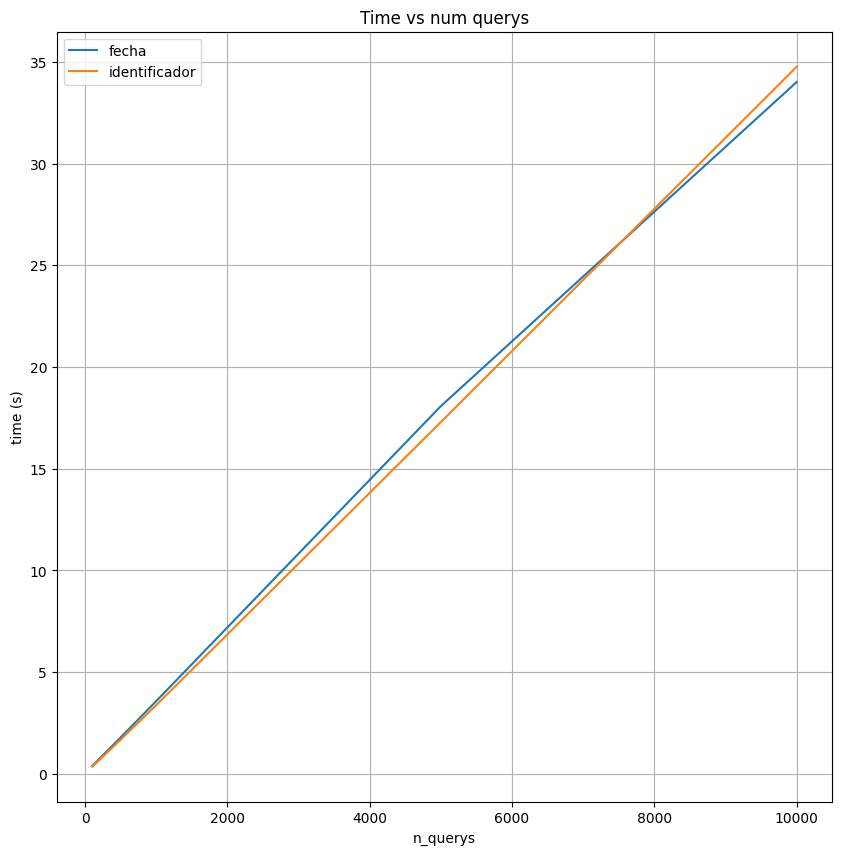

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
for query_type in times_graph:
    ax.plot(n_querys_graph, times_graph[query_type].values(), label=query_type)
ax.set(xlabel='n_querys', ylabel='time (s)', title='Time vs num querys')
ax.grid()
ax.legend()
plt.show()